# Gas Consumption Forecasting using LightGBM

This notebook demonstrates a comprehensive analysis of Romania's inland gas consumption using LightGBM for time series forecasting. The analysis includes:

1. Data preprocessing and exploration
2. Model development using LightGBM with recursive forecasting
3. Feature engineering with rolling windows
4. Hyperparameter optimization using Bayesian search
5. Feature selection and importance analysis
6. Model interpretation using SHAP values
7. Forecasting with uncertainty quantification

## Dependencies

The analysis requires several Python libraries for different aspects of the modeling process:
- Data manipulation: numpy, pandas
- Visualization: matplotlib, plotly
- Modeling: lightgbm, skforecast
- Model interpretation: shap

## Data Loading and Preprocessing

We load two main datasets:
1. `raw_data.csv`: Contains the target variable (Inland Gas Consumption)
2. `exog_data.csv`: Contains exogenous variables including economic indicators and dummy variables for significant events

The data is processed to ensure:
- Proper datetime indexing
- Monthly frequency (MS = Month Start)
- Correct data types for dummy variables

In [ ]:
# Data processing --Disclaimer: Install every library (skforecast, matplotlib etc.)
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)
plt.style.use('seaborn-v0_8-darkgrid')

# Modelling and Forecasting
# ==============================================================================
import lightgbm
import skforecast
import sklearn
from lightgbm import LGBMRegressor
from sklearn.feature_selection import RFECV
from skforecast.recursive import ForecasterRecursive
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.feature_selection import select_features
from skforecast.plot import plot_residuals
from skforecast.plot import plot_prediction_distribution
from skforecast.plot import plot_prediction_intervals
from skforecast.preprocessing import RollingFeatures
import shap
import eurostat

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')
warnings.simplefilter(action='ignore', category=FutureWarning)

print(f"{color}Version skforecast: {skforecast.__version__}")
print(f"{color}Version scikit-learn: {sklearn.__version__}")
print(f"{color}Version lightgbm: {lightgbm.__version__}")
print(f"{color}Version pandas: {pd.__version__}")
print(f"{color}Version numpy: {np.__version__}")

c:\Users\const\anaconda3\envs\lightgbm-icbe2025\Lib\site-packages\_plotly_utils\basevalidators.py:2596: DeprecationWarning:

*scattermapbox* is deprecated! Use *scattermap* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



Version skforecast: 0.15.0
Version scikit-learn: 1.6.1
Version lightgbm: 4.6.0
Version pandas: 2.2.3
Version numpy: 2.1.3


In [ ]:
data = pd.read_csv('Data/raw_data.csv', parse_dates=["Date"]) #modify to actual user path 
exog = pd.read_csv('Data/exog_data.csv', parse_dates=["Date"])


In [104]:
data = data.set_index("Date")
data = data.asfreq("MS")
data

,Inland Consumption
Date,
2014-01-01,1392.0
2014-02-01,1301.0
2014-03-01,1064.0
2014-04-01,954.0
2014-05-01,777.0
...,...
2024-09-01,438.0
2024-10-01,710.0
2024-11-01,1233.0


In [105]:

exog = exog.drop(columns=["Unnamed: 0"])
exog = exog.set_index("Date")
dummy_columns = ['COVID-19', 'European Energy Crisis', 'Russian-Ukraine Conflict']  # Replace with your actual dummy variable column names
exog[dummy_columns] = exog[dummy_columns].astype(int)
exog = exog.asfreq("MS")
exog

,Cons_sin,Cons_cos,COVID-19,European Energy Crisis,Russian-Ukraine Conflict
Date,,,,,
2014-01-01,5.000000e-01,8.660254e-01,0,0,0
2014-02-01,8.660254e-01,5.000000e-01,0,0,0
2014-03-01,1.000000e+00,6.123234e-17,0,0,0
2014-04-01,8.660254e-01,-5.000000e-01,0,0,0
2014-05-01,5.000000e-01,-8.660254e-01,0,0,0
...,...,...,...,...,...
2024-09-01,-1.000000e+00,-1.836970e-16,0,0,1
2024-10-01,-8.660254e-01,5.000000e-01,0,0,1
2024-11-01,-5.000000e-01,8.660254e-01,0,0,1


## Train-Validation-Test Split

The data is split into three parts to ensure robust model evaluation:
- Training set: Up to December 2019
- Validation set: January 2020 to August 2022
- Test set: September 2022 onwards

This split allows us to:
1. Train the model on historical data
2. Validate and tune hyperparameters
3. Evaluate final performance on unseen data

In [106]:
# Train - Validation - Testing
# =================================================
end_train      = "2019-12-01"
end_validation = "2022-08-01"

data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]

data_train = data_train.asfreq("MS")
data_val = data_val.asfreq("MS")
data_test = data_test.asfreq("MS")

# Print the results
print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validation : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 2014-01-01 00:00:00 --- 2019-12-01 00:00:00  (n=72)
Dates validation : 2019-12-01 00:00:00 --- 2022-08-01 00:00:00  (n=33)
Dates test       : 2022-08-01 00:00:00 --- 2025-01-01 00:00:00  (n=30)


In [107]:
# Iteractive plot of split sets
# =================================================
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_train.index,
                         y=data_train['Inland Consumption'],
                         mode='lines',
                         name='Train'))
fig.add_trace(go.Scatter(x=data_val.index,
                         y=data_val['Inland Consumption'],
                         mode='lines', name='Validation',
                         line=dict(color='purple')))
fig.add_trace(go.Scatter(x=data_test.index,
                         y=data_test['Inland Consumption'],
                         mode='lines',
                         name='Test'))

fig.update_layout(
    title = "Romania's Inland Gas Consumption ",
    title_x = 0.5,
    xaxis_title = "Time (Monthly frequency)",
    yaxis_title = "Million cubic meters",
    #legend_title = "Splits: ",
    width=1000,
    height=400,
    template="plotly_white",
    #legend=dict(orientation="h", yanchor="top", y=1, xanchor="left")
)

fig.show()

c:\Users\const\anaconda3\envs\lightgbm-icbe2025\Lib\site-packages\_plotly_utils\basevalidators.py:2596: DeprecationWarning:

*scattermapbox* is deprecated! Use *scattermap* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



## Model Development

We use LightGBM with recursive forecasting strategy:
- Base model: LightGBM Regressor
- Recursive strategy: Uses predictions as inputs for future steps
- Feature engineering: Rolling statistics (mean, std) with various window sizes
- Differencing: First-order differentiation to handle non-stationarity

Initial configuration:
- 12 lags (1 year of historical data)
- Rolling windows: 3, 6, and 12 months
- Statistics: mean and standard deviation

## Model Evaluation and Backtesting

The model is evaluated using several metrics:
- Mean Absolute Error (MAE)
- Mean Absolute Percentage Error (MAPE)
- Root Mean Squared Scaled Error (RMSSE)

We use a backtesting approach with:
- 3-step ahead predictions
- Rolling validation windows
- 90% confidence intervals for uncertainty quantification

In [108]:
# Create forecaster
# ==============================================================================
window_features = RollingFeatures(stats=["mean", "mean", "mean", "std", "std", "std"], window_sizes= [3, 6, 12, 3, 6, 12])
forecaster = ForecasterRecursive(
                regressor       = LGBMRegressor(random_state=15926, verbose=-1),
                lags            = 12,
                window_features = window_features,
                differentiation = 1
             )
warnings.simplefilter(action='ignore', category=FutureWarning)


# Train forecaster
# ==============================================================================
forecaster.fit(y=data.loc[:end_validation, 'Inland Consumption'])
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: LGBMRegressor 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
Window features: ['roll_mean_3', 'roll_mean_6', 'roll_mean_12', 'roll_std_3', 'roll_std_6', 'roll_std_12'] 
Window size: 13 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: 1 
Training range: [Timestamp('2014-01-01 00:00:00'), Timestamp('2022-08-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None,
    'random_state': 15926, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample':
    1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2025-03-24 18:39:54 
Last fit date: 2025-03-24 18:39:54 
Skforecast version: 0.15.0 
Python version: 3.13.2 
Forecaster id: None

In [109]:
forecaster.predict(steps=10)

2022-09-01     535.327689
2022-10-01     754.260046
2022-11-01    1072.098122
2022-12-01    1380.806458
2023-01-01    1629.011503
2023-02-01    1325.118771
2023-03-01    1100.964965
2023-04-01     730.625324
2023-05-01     475.011047
2023-06-01     419.852998
Freq: MS, Name: pred, dtype: float64

In [110]:
# Backtest model on validation data
# ==============================================================================

cv = TimeSeriesFold(
        steps              = 3,
        initial_train_size = len(data[:end_train]),
        refit              = True,
        differentiation    = 1
)
metric, predictions = backtesting_forecaster(
                            forecaster    = forecaster,
                            y             = data.loc[:end_validation,'Inland Consumption'],
                            cv            = cv,
                            metric        = ['mean_absolute_error', 'mean_absolute_percentage_error', 'root_mean_squared_scaled_error'],
                            n_jobs        = 'auto',
                            verbose       = False, # Change to False to see less information
                            show_progress = True
                       )

warnings.simplefilter(action='ignore', category=FutureWarning)

predictions.head()

  0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 11/11 [00:00<00:00, 52.37it/s]


,pred
2020-01-01,1618.939491
2020-02-01,1532.464240
2020-03-01,1305.606049
2020-04-01,823.171809
2020-05-01,507.091962


In [111]:
metric

,mean_absolute_error,mean_absolute_percentage_error,root_mean_squared_scaled_error
0,164.961665,0.188377,0.780575


In [112]:
# Backtesting model with exogenous variables on test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                            forecaster    = forecaster,
                            y             = data['Inland Consumption'],
                            cv            = cv,
                           # exog          = exog,
                            metric        = ['mean_absolute_error', 'mean_absolute_percentage_error','root_mean_squared_scaled_error'],
                            n_jobs        = 'auto',
                            verbose       = False, # Change to False to see less information
                            show_progress = True
                       )

metric

100%|██████████| 21/21 [00:00<00:00, 66.67it/s]


,mean_absolute_error,mean_absolute_percentage_error,root_mean_squared_scaled_error
0,141.956762,0.175845,0.700696


In [113]:
# Backtest model on test data
# ==============================================================================

cv = TimeSeriesFold(
        steps              = 3,
        initial_train_size = len(data[:end_validation]),
        refit              = True,
        differentiation    = 1
)
metric, predictions = backtesting_forecaster(
                            forecaster    = forecaster,
                            y             = data['Inland Consumption'],
                            cv            = cv,
                            metric        = ['mean_absolute_error', 'mean_absolute_percentage_error', 'root_mean_squared_scaled_error'],
                            n_jobs        = 'auto',
                            verbose       = False, # Change to False to see less information
                            show_progress = True
                       )

warnings.simplefilter(action='ignore', category=FutureWarning)

predictions.head()

100%|██████████| 10/10 [00:00<00:00, 54.13it/s]


,pred
2022-09-01,535.327689
2022-10-01,754.260046
2022-11-01,1072.098122
2022-12-01,1244.021186
2023-01-01,1499.208741


In [114]:
metric

,mean_absolute_error,mean_absolute_percentage_error,root_mean_squared_scaled_error
0,93.997097,0.134063,0.448091


In [115]:
# Backtesting model with exogenous variables on test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                            forecaster    = forecaster,
                            y             = data['Inland Consumption'],
                            cv            = cv,
                            exog          = exog,
                            metric        = ['mean_absolute_error', 'mean_absolute_percentage_error','root_mean_squared_scaled_error'],
                            n_jobs        = 'auto',
                            verbose       = False, # Change to False to see less information
                            show_progress = True
                       )

100%|██████████| 10/10 [00:00<00:00, 40.63it/s]


In [116]:
metric

,mean_absolute_error,mean_absolute_percentage_error,root_mean_squared_scaled_error
0,92.883784,0.131783,0.451011


## Feature Selection and Importance

Feature selection is performed using Recursive Feature Elimination with Cross-Validation (RFECV):
- Evaluates different combinations of features
- Selects optimal lag values
- Identifies important rolling statistics
- Determines relevant exogenous variables

This helps reduce model complexity while maintaining performance.

In [117]:
# Hyperparameters search
# ==============================================================================
# Create forecaster
forecaster = ForecasterRecursive(
                regressor       = LGBMRegressor(random_state=15926, verbose=-1),
                lags            = 12,
                window_features = window_features,
                differentiation = 1
            )


# Lags grid
lags_grid = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

warnings.simplefilter(action='ignore', category=FutureWarning)

# Regressor hyperparameters search space
def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 20, 200, step=5),
        'max_depth'       : trial.suggest_int('max_depth', 5, 80, step=5),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 100, step=5),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 0.05),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1, step=0.05),
        'max_bin'         : trial.suggest_int('max_bin', 10, 200, step=5),
        'reg_alpha'       : trial.suggest_float('reg_alpha', 0, 1, step=0.01),
        'reg_lambda'      : trial.suggest_float('reg_lambda', 0, 1, step=0.01),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space

# Folds
cv_search = TimeSeriesFold(
                steps              = 3,
                initial_train_size = len(data_train),
                refit              = True,
                differentiation    = 1 
            )

results_search, frozen_trial = bayesian_search_forecaster(
                                    forecaster    = forecaster,
                                    y             = data.loc[:end_validation, 'Inland Consumption'],
                                    exog          = exog.loc[:end_validation, :],
                                    search_space  = search_space,
                                    cv            = cv_search,
                                    metric        = ['mean_absolute_error', 'mean_absolute_percentage_error','root_mean_squared_scaled_error'],
                                    n_trials      = 100,
                                    random_state  = 15926,
                                    return_best   = True,
                                    n_jobs        = 'auto',
                                    verbose       = False,
                                    show_progress = True
                                )
best_params = results_search['params'].iat[0]
best_lags = results_search['lags'].iat[0]

Best trial: 32. Best value: 129.005: 100%|██████████| 100/100 [00:25<00:00,  3.87it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5] 
  Parameters: {'n_estimators': 155, 'max_depth': 50, 'min_data_in_leaf': 20, 'learning_rate': 0.04132823801511771, 'feature_fraction': 0.6, 'max_bin': 25, 'reg_alpha': 0.63, 'reg_lambda': 0.66}
  Backtesting metric: 129.00540954585205


In [118]:
results_search.head(3)


,lags,params,mean_absolute_error,mean_absolute_percentage_error,root_mean_squared_scaled_error,n_estimators,max_depth,min_data_in_leaf,learning_rate,feature_fraction,max_bin,reg_alpha,reg_lambda
0,"[1, 2, 3, 4, 5]","{'n_estimators': 155, 'max_depth': 50, 'min_da...",129.005410,0.156561,0.628911,155.0,50.0,20.0,0.041328,0.60,25.0,0.63,0.66
1,"[1, 2, 3, 4, 5]","{'n_estimators': 185, 'max_depth': 55, 'min_da...",129.415501,0.157239,0.624677,185.0,55.0,20.0,0.036706,0.65,35.0,0.74,0.68
2,"[1, 2, 3]","{'n_estimators': 170, 'max_depth': 20, 'min_da...",135.652693,0.151903,0.645345,170.0,20.0,20.0,0.045600,0.70,10.0,1.00,0.70


In [119]:
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: LGBMRegressor 
Lags: [1 2 3 4 5] 
Window features: ['roll_mean_3', 'roll_mean_6', 'roll_mean_12', 'roll_std_3', 'roll_std_6', 'roll_std_12'] 
Window size: 13 
Exogenous included: True 
Exogenous names: 
    Cons_sin, Cons_cos, COVID-19, European Energy Crisis, Russian-Ukraine Conflict 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: 1 
Training range: [Timestamp('2014-01-01 00:00:00'), Timestamp('2022-08-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.04132823801511771,
    'max_depth': 50, 'min_child_samples': 20, 'min_child_weight': 0.001,
    'min_split_gain': 0.0, 'n_estimators': 155, 'n_jobs': None, 'num_leaves':
    31, 'objective': None, 'random_state': 15926, 'reg_alpha': 0.63,
    'reg_lambda': 0.66, 'subsample': 1.0, 'subsample_for_bin': 200000,
    'subsample_freq': 0, 'verbose': -1, 'min_data_in_leaf': 20,
    'feature_fraction': 0.6, 'max_bin': 25} 
fit_kwargs: {} 
Creation date: 2025-03-24 18:39:55 
Last fit date: 2025-03-24 18:40:21 
Skforecast version: 0.15.0 
Python version: 3.13.2 
Forecaster id: None

In [120]:
# Backtesting model with exogenous variables on test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                            forecaster    = forecaster,
                            y             = data['Inland Consumption'],
                            exog          = exog,
                            cv            = cv,
                            metric        = ['mean_absolute_error', 'mean_absolute_percentage_error', 'root_mean_squared_scaled_error'],
                            n_jobs        = 'auto',
                            verbose       = False,
                            show_progress = True,
                            interval = [5, 95]
                       )
display(metric)
predictions.head()

100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


,mean_absolute_error,mean_absolute_percentage_error,root_mean_squared_scaled_error
0,99.92945,0.141252,0.465618


,pred,lower_bound,upper_bound
2022-09-01,504.531662,288.243288,650.496359
2022-10-01,763.175105,480.152987,999.561024
2022-11-01,1106.351816,726.133217,1310.539600
2022-12-01,1267.123458,1157.066961,1449.026260
2023-01-01,1421.144167,1313.656672,1641.068251


In [121]:
# Plot Test data versus Predicted with 80% confidence interval
# ==============================================================================
fig = go.Figure()

# Actual values
fig.add_trace(go.Scatter(
    x=data_test.index, 
    y=data_test['Inland Consumption'], 
    name="Test", 
    mode="lines",
    line=dict(color="black")
))
# Predictions
fig.add_trace(go.Scatter(
    x=predictions.index, 
    y=predictions['pred'], 
    name="Prediction", 
    mode="lines",
    line=dict(color="red")
))

# Upper bound (Shaded area)
fig.add_trace(go.Scatter(
    x=predictions.index, 
    y=predictions['upper_bound'], 
    mode='lines',
    line=dict(width=0),  # No line, just for shading
    showlegend=False
))

# Lower bound (Shaded area)
fig.add_trace(go.Scatter(
    x=predictions.index, 
    y=predictions['lower_bound'], 
    mode='lines',
    fill='tonexty',  # Fill between this trace and the previous one
    fillcolor='rgba(255, 0, 0, 0.3)',  # Semi-transparent red
    line=dict(width=0),  # No line
    name='90% Interval'
))

mae  = metric['mean_absolute_error']
mape = metric['mean_absolute_percentage_error']
rmsse = metric['root_mean_squared_scaled_error']

# Layout
fig.update_layout(
    title={
        'text': f"Real versus predicted values in test data set<br><sup>MAE: {mae.values[0]:.2f}, MAPE: {mape.values[0]:.2%}, RMSSE: {rmsse.values[0]:.2f}</sup>",
        'x': 0.5
    },
    title_x=0.5,
    xaxis_title="Time (Monthly frequency)",
    yaxis_title="Million cubic meters",
    width=750,
    height=350,
    template="plotly_white", 
    margin=dict(l=20, r=20, t=35, b=20),
    #legend=dict(orientation="h", yanchor="top", y=1.1, xanchor="left", x=0.001)
)

# Show figure
fig.show()

c:\Users\const\anaconda3\envs\lightgbm-icbe2025\Lib\site-packages\_plotly_utils\basevalidators.py:2596: DeprecationWarning:

*scattermapbox* is deprecated! Use *scattermap* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



In [122]:
# Out-of-Sample prediction :: PILOT FORECAST
# ==============================================================================
forecaster.fit(y=data['Inland Consumption'])
predictions = forecaster.predict(steps = 36)

fig = go.Figure()
fig.add_trace(go.Scatter(x=predictions.index,
                         y=predictions, mode='lines',
                         name='Predicted',
                         line=dict(color='red')))
fig.add_trace(go.Scatter(x=data.index,
                         y=data['Inland Consumption'],
                         mode='lines',
                         name='Observed',
                         line=dict(color='blue')))

fig.update_layout(
    title = "Romania's Inland Gas Consumption Prediction for 36 months :: PILOT FORECAST",
    title_x = 0.5,
    xaxis_title = "Time (Monthly frequency)",
    yaxis_title = "Million cubic meters",
    #legend_title = "Variables: ",
    width=1200,
    height=400,
    template="plotly_white",
    #legend=dict(orientation="h", yanchor="top", y=1, xanchor="left")
)

fig.show()

c:\Users\const\anaconda3\envs\lightgbm-icbe2025\Lib\site-packages\_plotly_utils\basevalidators.py:2596: DeprecationWarning:

*scattermapbox* is deprecated! Use *scattermap* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



## Model Interpretation with SHAP Values

SHAP (SHapley Additive exPlanations) values help understand the model:
- Feature importance ranking
- Individual prediction explanations
- Impact of each variable on predictions
- Direction and magnitude of feature effects

The force plots and summary plots provide insights into the model's decision-making process.

In [123]:
# Feature selection
# ==============================================================================
regressor = LGBMRegressor(
    n_estimators = 190,
    max_depth = 45,
    min_data_in_leaf = 15,
    learning_rate = 0.05
)

forecaster = ForecasterRecursive(
    regressor = regressor,
    lags = 12,
    window_features = window_features,
    differentiation = 1
)

# Reccursive feature elimination with cross-validation
# ==============================================================================

selector = RFECV(
    estimator = regressor,
    step = 1,
    cv = 24,
    n_jobs = -1
)

lags_selected, window_features_select, exog_selected = select_features(
    forecaster = forecaster,
    selector = selector,
    y = data.loc[:end_validation,"Inland Consumption"],
    exog=exog.loc[:end_validation, :],
    select_only = None,
    force_inclusion = None,
    subsample = 0.7,
    random_state = 15926,
    verbose = True,
)

warnings.simplefilter(action='ignore', category=FutureWarning)

Recursive feature elimination (RFECV)
-------------------------------------
Total number of records available: 91
Total number of records used for feature selection: 63
Number of features available: 23
    Lags            (n=12)
    Window features (n=6)
    Exog            (n=5)
Number of features selected: 20
    Lags            (n=12) : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    Window features (n=6) : ['roll_mean_3', 'roll_mean_6', 'roll_mean_12', 'roll_std_3', 'roll_std_6', 'roll_std_12']
    Exog            (n=2) : ['Cons_sin', 'Cons_cos']


In [124]:
# Create a forecaster with the selected features
# ==============================================================================
window_features_selected = RollingFeatures(stats=["mean", "std", "std"], window_sizes= [12, 6, 12])

forecaster = ForecasterRecursive(
    regressor       = LGBMRegressor(**best_params, random_state=15926, verbose=-1),
    lags            = lags_selected,
    window_features = window_features,
    differentiation = 1
)


# Backtesting model on test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
    forecaster    = forecaster,
    y             = data['Inland Consumption'],
    exog          = exog[exog_selected],
    cv            = cv,
    metric        = ['mean_absolute_error', 'mean_absolute_percentage_error', 'root_mean_squared_scaled_error'], 
    n_jobs        = 'auto',
    verbose       = False,
    show_progress = True
)

metric

100%|██████████| 10/10 [00:00<00:00, 42.10it/s]


,mean_absolute_error,mean_absolute_percentage_error,root_mean_squared_scaled_error
0,82.586432,0.101316,0.427073


In [125]:
# Calculate residuals
residuals = data_test["Inland Consumption"] - predictions["pred"]
residuals = residuals.dropna()
print(residuals)

2022-09-01    -48.327205
2022-10-01   -121.079401
2022-11-01   -132.473604
2022-12-01     31.919104
2023-01-01   -254.059743
2023-02-01   -162.861641
2023-03-01    -40.188534
2023-04-01     39.651998
2023-05-01     -4.931937
2023-06-01    -79.337072
2023-07-01    -40.834248
2023-08-01    -42.366736
2023-09-01     30.600341
2023-10-01     -2.264485
2023-11-01    180.900102
2023-12-01     67.010827
2024-01-01    170.097789
2024-02-01     36.212827
2024-03-01     -7.173754
2024-04-01   -200.359792
2024-05-01     28.004012
2024-06-01     24.731263
2024-07-01     42.018644
2024-08-01     23.551752
2024-09-01    -61.209222
2024-10-01    -62.794216
2024-11-01    173.448781
2024-12-01   -123.537241
2025-01-01   -163.060266
Freq: MS, dtype: float64


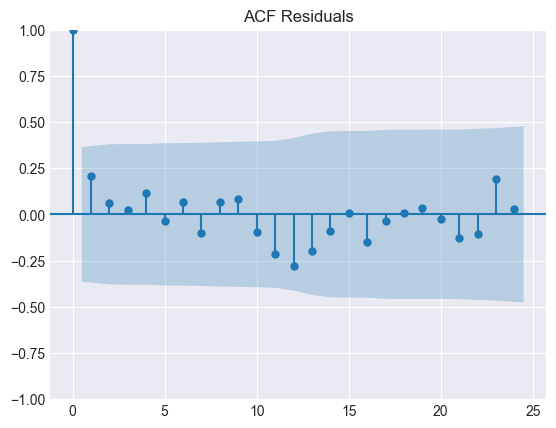

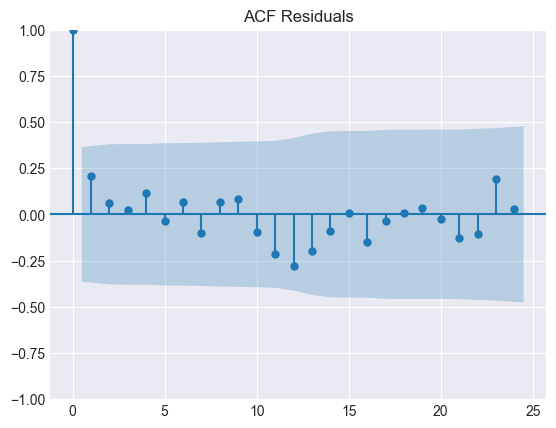

In [126]:
plot_acf(residuals, lags=24, title="ACF Residuals")

In [127]:
window_features_select

['roll_mean_3',
 'roll_mean_6',
 'roll_mean_12',
 'roll_std_3',
 'roll_std_6',
 'roll_std_12']

In [128]:
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: LGBMRegressor 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
Window features: ['roll_mean_3', 'roll_mean_6', 'roll_mean_12', 'roll_std_3', 'roll_std_6', 'roll_std_12'] 
Window size: 13 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: 1 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.04132823801511771,
    'max_depth': 50, 'min_child_samples': 20, 'min_child_weight': 0.001,
    'min_split_gain': 0.0, 'n_estimators': 155, 'n_jobs': None, 'num_leaves':
    31, 'objective': None, 'random_state': 15926, 'reg_alpha': 0.63,
    'reg_lambda': 0.66, 'subsample': 1.0, 'subsample_for_bin': 200000,
    'subsample_freq': 0, 'min_data_in_leaf': 20, 'feature_fraction': 0.6,
    'max_bin': 25, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2025-03-24 18:40:43 
Last fit date: None 
Skforecast version: 0.15.0 
Python version: 3.13.2 
Forecaster id: None

In [129]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
    regressor       = LGBMRegressor(**best_params, random_state=15926, verbose=-1),
    lags            = lags_selected,
    window_features = window_features_selected,
    differentiation = 1
)
forecaster.fit(
    y    = data['Inland Consumption'],
    exog = exog[exog_selected],
    store_in_sample_residuals=True
)

# Extract feature importance
# ==============================================================================
importance = forecaster.get_feature_importances()
importance

,feature,importance
12,roll_mean_12,67
15,Cons_sin,63
0,lag_1,55
16,Cons_cos,49
6,lag_7,44
11,lag_12,34
1,lag_2,33
2,lag_3,33
10,lag_11,33
3,lag_4,32


In [130]:
# Training matrices used by the forecaster to fit the internal regressor
# ==============================================================================
X_train, y_train = forecaster.create_train_X_y(
                       y    = data.loc[:end_validation, 'Inland Consumption'],
                       exog = exog.loc[:end_validation, exog_selected]
                   )
display(X_train.head(3))
display(y_train.head(3))


,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,roll_mean_12,roll_std_6,roll_std_12,Cons_sin,Cons_cos
Date,,,,,,,,,,,,,,,,,
2015-02-01,146.0,6.0,521.0,-67.0,39.0,-29.0,-149.0,99.0,-177.0,-110.0,-237.0,-91.0,-4.083333,217.440260,199.846513,0.866025,5.000000e-01
2015-03-01,-134.0,146.0,6.0,521.0,-67.0,39.0,-29.0,-149.0,99.0,-177.0,-110.0,-237.0,-7.666667,233.768618,201.921377,1.000000,6.123234e-17
2015-04-01,-41.0,-134.0,146.0,6.0,521.0,-67.0,39.0,-29.0,-149.0,99.0,-177.0,-110.0,8.666667,239.148002,189.211442,0.866025,-5.000000e-01


Date
2015-02-01   -134.0
2015-03-01    -41.0
2015-04-01   -300.0
Freq: MS, Name: y, dtype: float64

In [131]:
# Create SHAP explainer (for three base models)
# ==============================================================================

explainer = shap.TreeExplainer(forecaster.regressor)
shap_values = explainer.shap_values(X_train)


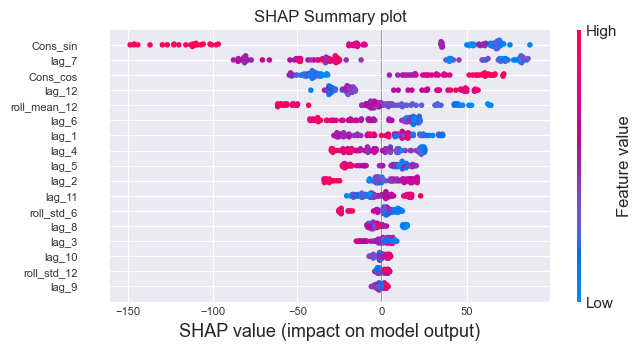

In [132]:
# Shap summary plot 
# ==============================================================================
shap.initjs()
shap.summary_plot(shap_values, X_train, max_display=17, show=False)
fig, ax = plt.gcf(), plt.gca()
ax.set_title("SHAP Summary plot")
ax.tick_params(labelsize=8)
fig.set_size_inches(7, 3)

In [133]:
# Force plot for the first observation
# ==============================================================================
shap.initjs()
force_plot_html = shap.force_plot(explainer.expected_value, shap_values[:,:], X_train.iloc[:,:])

In [134]:
force_plot_html

## Forecasting with Uncertainty

Final forecasts are generated with uncertainty quantification:
- Bootstrap sampling for multiple prediction sequences
- Quantile predictions (5%, 25%, 50%, 75%, 95%)
- Visualization of prediction distributions
- Confidence intervals for risk assessment

This provides a comprehensive view of potential future scenarios.

In [135]:
# Out of sample forecaster
# ==============================================================================
forecaster.fit(y=data['Inland Consumption'])
predictions = forecaster.predict(steps = 36)

fig = go.Figure()
fig.add_trace(go.Scatter(x=predictions.index,
                         y=predictions, mode='lines',
                         name='Predicted',
                         line=dict(color='red')))
fig.add_trace(go.Scatter(x=data.index,
                         y=data['Inland Consumption'],
                         mode='lines',
                         name='Observed',
                         line=dict(color='blue')))

fig.update_layout(
    title = "Romania's Inland Gas Consumption Prediction for 36 months",
    title_x = 0.5,
    xaxis_title = "Time (Monthly frequency)",
    yaxis_title = "Million cubic meters",
    #legend_title = "Variables: ",
    width=1200,
    height=400,
    template="plotly_white",
    #legend=dict(orientation="h", yanchor="top", y=1, xanchor="left")
)

fig.show()

c:\Users\const\anaconda3\envs\lightgbm-icbe2025\Lib\site-packages\_plotly_utils\basevalidators.py:2596: DeprecationWarning:

*scattermapbox* is deprecated! Use *scattermap* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



In [136]:
forecaster.fit(
    y    = data['Inland Consumption'],
    # exog = exog[exog_selected],
    store_in_sample_residuals=True
)
# Predict 200 different forecasting sequences of 24 steps each using bootstrapping
# ==============================================================================
boot_predictions = forecaster.predict_bootstrapping(
                       steps  = 36,
                       n_boot = 200
                   )

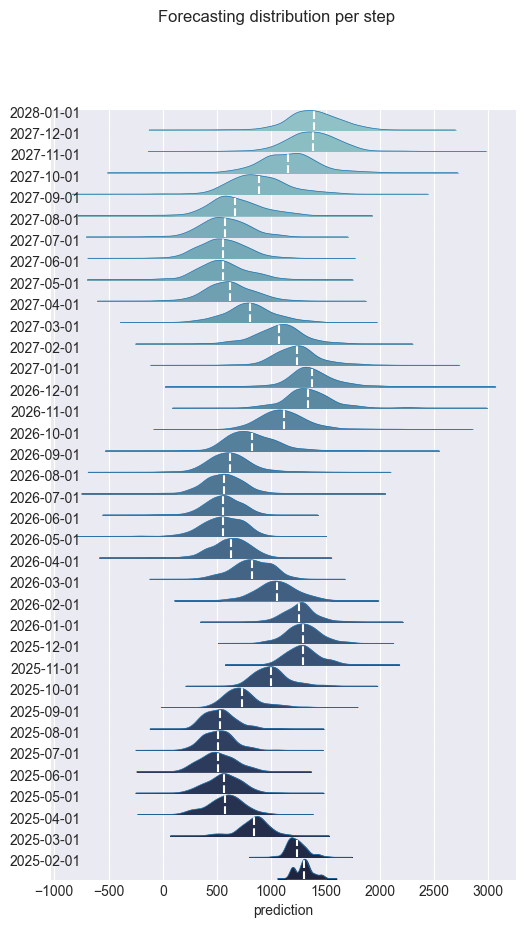

In [137]:
_ = plot_prediction_distribution(boot_predictions, figsize=(6, 10))

In [138]:
predictions_quantiles = forecaster.predict_quantiles(
                  steps     = 36,
                  n_boot    = 200,
                  quantiles = [0.05, 0.25, 0.50, 0.75, 0.95],
              )
predictions_quantiles

,q_0.05,q_0.25,q_0.5,q_0.75,q_0.95
2025-02-01,1192.755687,1261.584759,1303.340690,1329.167787,1463.764517
2025-03-01,1129.296998,1174.593299,1227.428697,1278.535545,1425.050091
2025-04-01,554.230004,782.716752,858.601602,920.351960,1022.476597
2025-05-01,277.300060,480.160748,585.384358,688.376129,816.761349
2025-06-01,312.552582,464.475264,566.034337,664.004561,803.611482
2025-07-01,268.025656,401.438918,494.603815,621.969849,793.078625
2025-08-01,301.750987,403.620584,506.231293,601.782090,766.964790
2025-09-01,336.917434,421.464999,523.972558,602.243390,799.120743
2025-10-01,527.234717,629.079757,709.527711,796.556849,1074.029303
2025-11-01,792.883344,892.845396,983.427434,1072.011022,1296.060678


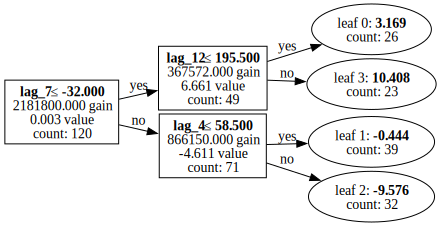

In [139]:
# Visualisation of the regressor
import graphviz
# Create a more detailed tree visualization
lightgbm.create_tree_digraph(forecaster.regressor, 
                       tree_index=5,  # visualize first tree
                       show_info=['split_gain', 'internal_value', 'internal_count', 'leaf_count'],
                       name='tree_plot',
                       format='png')

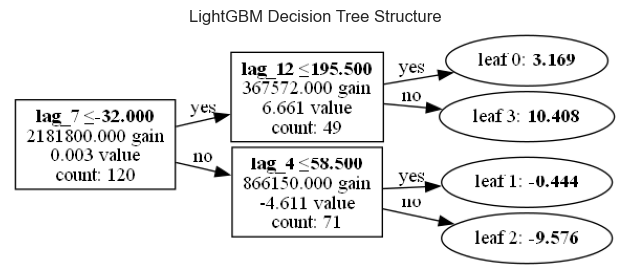

In [140]:
lightgbm.plot_tree(
    booster=forecaster.regressor,  # your trained model
    tree_index=5,  # first tree
    show_info=['split_gain', 'internal_value', 'internal_count'],
    precision=3,
    orientation='horizontal'
)

plt.title('LightGBM Decision Tree Structure')
plt.tight_layout()
plt.show()


<Axes: title={'center': 'Split value histogram for feature with index 0'}, xlabel='Feature split value', ylabel='Count'>

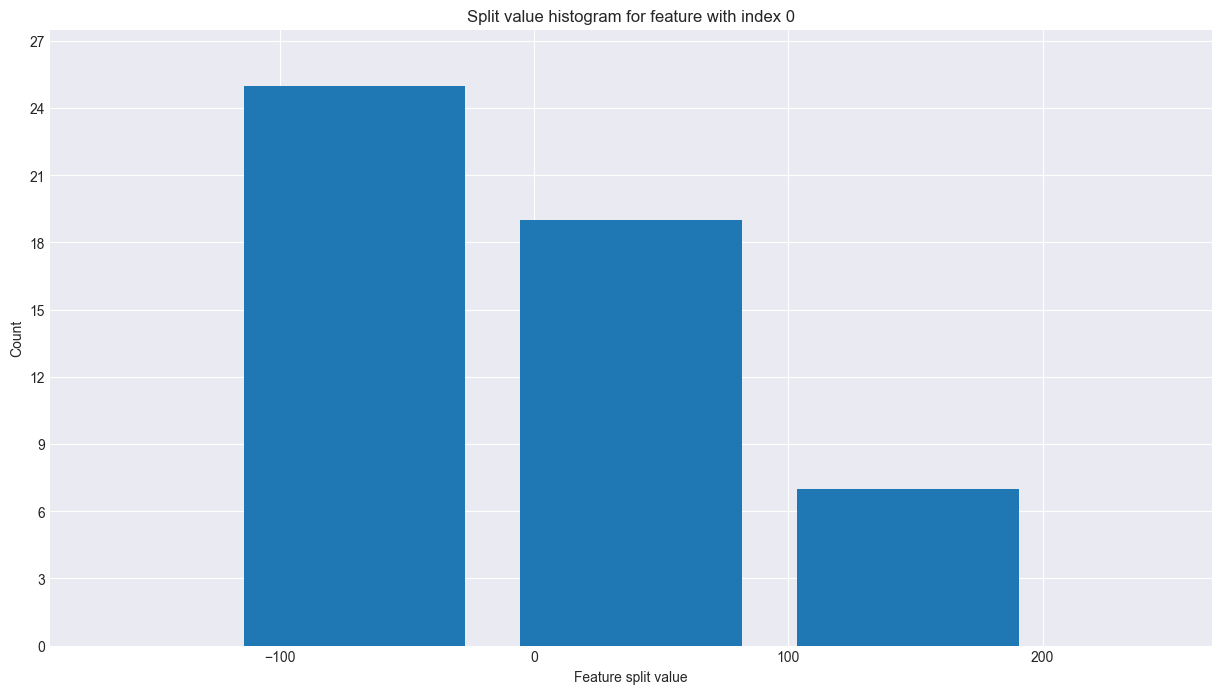

In [141]:
lightgbm.plot_split_value_histogram(
    booster=forecaster.regressor,
    feature=0,  # index of the feature to analyze
    bins=3,    # number of bins in histogram
    figsize=(15, 8)
)
